# Example of using LSTM for Sequence data prediction

This notebook illustrates using LSTM implemented in pytorch for sequence regression predictions.

The concept is shown on two conditions:
1- Using dataset from: [Dataset](https://www.kaggle.com/datasets/rakannimer/air-passengers)
2- Nonlinear spiral motion

The simple model is an LSTM layer, the output of last LSTM unit is followed by a dense layer and ouput with a Mean Squared Error loss function is trained to predict the output based on the previous points.

Initially it is assumed that the step size between points is fixed for both of the examples, but the model can be extended for varied step sizes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#torch.manual_seed(1)

## Loading the data

In [2]:
dataframe = pandas.read_csv('./data/AirPassengers.csv', usecols=[1], engine='python')
dataframe.head()

,#Passengers
0,112
1,118
2,132
3,129
4,121


## Data visualization

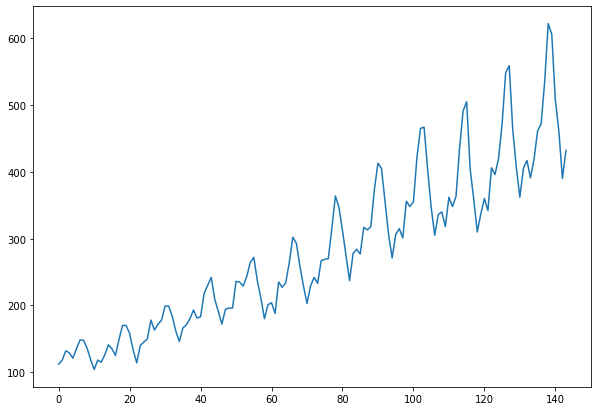

In [3]:
fig = plt.figure(figsize = (10, 7))
data = dataframe.values
plt.plot(data)
plt.show()

For model to work properly need to scale the data between 0 and 1 or do other types of normalization:

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(data)

# Ploting the scaled version skipped to keep the notebook simpler
#fig = plt.figure(figsize = (10, 7))
#plt.plot(normalized_data)
#plt.show()

## Data pre-processing

First we split the data into train and test. Since it is a sequence data, we need to pick a split point. Data before the split point is used as training, and the data after that is the test dataset.

In [5]:
test_size = 0.25
n = len(data)
split_point = int((1 - test_size) * n)

train_data  = normalized_data[0:split_point] 
test_data   = normalized_data[split_point:n]

print(len(train_data), len(test_data))

108 36


The model will be trained based on previous points, the number of previous datapoinst is a hyper-parameter that we can experiment with. Lets assumed that the number of previous points we want to use if p. So each datapoint for training from the data set d is:


$ d = [d_0, d_1, d_2, ..., d_n] $

$ (x, y)^i = \left( [d_{i-p}, d_{i_p+1},..., d_{i-1}], d_i \right) $

When we only look at one point before for each point $ p = 1 $:

$ (x, y)^i = \left( [d_{i-1}], d_i \right) $

The function below is used to make the dataset as described above.

In [6]:
def make_data(data, past_points):
    n = len(data)
    X = []
    Y = []
    for i in range(past_points, n):
        x = data[i - past_points:i, 0]
        y = data[i, 0]
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)    

Start with using only one point before:

In [7]:
past_points = 1
train_X, train_Y = make_data(train_data, past_points = past_points)
test_X, test_Y = make_data(test_data, past_points = past_points)

We need to reshapre the input to the LSTM based on torch LSTM format [Link](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

According to the instruction the input shape should be $N,L,H_{in}$ where N is the number of samples, L is sequence length, and $H_{in}$ is the number of features.

The number of features depends on the p that we define above and sequence length is equal to one because we are inputing are already putting the sequence as input features.

We reshape the train and test data and transform them into torch tensors for the model.

In [8]:
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

train_data_tensor   = torch.tensor(train_X, dtype = torch.float32)
train_target_tensor = torch.tensor(train_Y, dtype = torch.float32)
test_data_tensor   = torch.tensor(test_X, dtype = torch.float32)
test_target_tensor = torch.tensor(test_Y, dtype = torch.float32)

## Setting up the model

We define the initialization with the model of a LSTM layer, input size is the number of features that depends on p, and hidden state size is a hyper-parameter that we can experiment with.

The last output layer has no activation since we are doing a regression mode. 

torch LSTM return different outputs but we are only interested in the hidden state of the last layer.


In [9]:
class LSTM_Regression(nn.Module):
    def __init__(self, input_size, hidden_size):
        self.hidden_size = hidden_size
        super().__init__()
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, batch_first=True)
        self.l1   = nn.Linear(in_features = hidden_size, out_features = 1)

    def forward(self, x):
        _, (h, _) = self.lstm(x)
        out = self.l1(h[0]).flatten()
        return out
    
    def evaluate(self, x):
        #model.eval()
        with torch.no_grad():
            _, (h, _) = self.lstm(x)
            out = self.l1(h[0]).flatten()
        return out    

## Setting up optimizer and loss function

Since it is a regression model, we use Mean Square Error for the loss function.

In [10]:
learning_rate = 5e-5
num_hidden_units = 4

model = LSTM_Regression(input_size = past_points, hidden_size = num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

## Training the model

In [11]:
model.train()
for step in range(20000):
    output  = model(train_data_tensor)
    loss    = loss_function(output, train_target_tensor)
    
    if step % 1000 == 0:
        print("step " + str(step) + " Loss : " + str(loss.item()))
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()    

step 0 Loss : 0.08527342975139618
step 1000 Loss : 0.048541996628046036
step 2000 Loss : 0.030929971486330032
step 3000 Loss : 0.022785736247897148
step 4000 Loss : 0.019602162763476372
step 5000 Loss : 0.01730811782181263
step 6000 Loss : 0.014468834735453129
step 7000 Loss : 0.011249013245105743
step 8000 Loss : 0.008053329773247242
step 9000 Loss : 0.005339683964848518
step 10000 Loss : 0.0035009828861802816
step 11000 Loss : 0.00263578281737864
step 12000 Loss : 0.0024186542723327875
step 13000 Loss : 0.002394153503701091
step 14000 Loss : 0.002384031191468239
step 15000 Loss : 0.0023744679056108
step 16000 Loss : 0.002366811502724886
step 17000 Loss : 0.002361966297030449
step 18000 Loss : 0.0023597877006977797
step 19000 Loss : 0.0023591520730406046


# Evaluating the model

First, we evaluate the MSE for the training and test datasets. For this we need to pass the input X to the model.

In [12]:
test_y_hat = model.evaluate(test_data_tensor)
train_y_hat = model.evaluate(train_data_tensor)

loss_test    = loss_function(test_y_hat, test_target_tensor)
loss_train    = loss_function(train_y_hat, train_target_tensor)

print("MSE train:" + str(loss_train))
print("MSE test :" + str(loss_test))

MSE train:tensor(0.0024)
MSE test :tensor(0.0104)


Next, we plot the predictions together with the original data.

We need to detach the torch tensors and put them into numpy with dimension 1.

In [13]:
train_y_hat = train_y_hat.detach().cpu().numpy()
train_y_hat = np.reshape(train_y_hat, (-1, 1))

test_y_hat = test_y_hat.detach().cpu().numpy()
test_y_hat = np.reshape(test_y_hat, (-1, 1))

Created first an empty array with the same dimension of original data and placed the train and test predictions into it according based on the split point between the train and test data.

For better, visualization we use the inverse of our scaler to bring them back into the original range.

In [14]:
predictions_train = np.empty_like(normalized_data)
predictions_train[:,:] = np.nan
predictions_train[past_points:split_point, :] = train_y_hat

predictions_test = np.empty_like(normalized_data)
predictions_test[:,:] = np.nan
predictions_test[split_point+past_points:n, :] = test_y_hat

predictions_train = scaler.inverse_transform(predictions_train)
predictions_test = scaler.inverse_transform(predictions_test)

Now, we can plot and visualize the result.

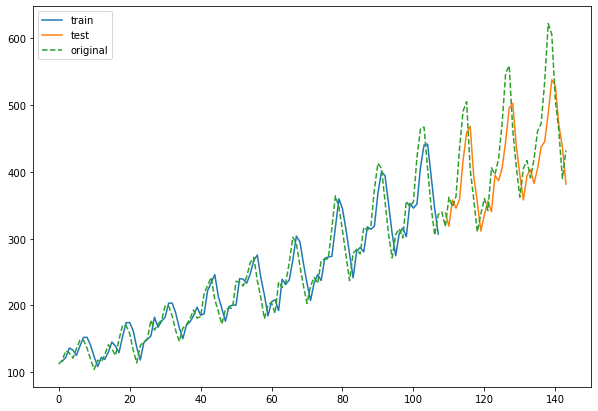

In [15]:
fig = plt.figure(figsize = (10, 7))
plt.plot(predictions_train, label = 'train')
plt.plot(predictions_test, label = 'test')
plt.plot(data, '--', label = 'original')
plt.legend()
plt.show()

# Predictions in a Nonlinear Motion

This concept can be extended much further and include states such as accelaration and speed, but for start this is similar to a constant velocity motion as the time steps are also equal.

First we create the data for a spiral and plot it. Noise with an arbitrary magnitude is added to the data.

the x, and y cooridinate change vs. time. So we need to estimators, one for x and one for y. For this we need to assume x and y to be independent initially.

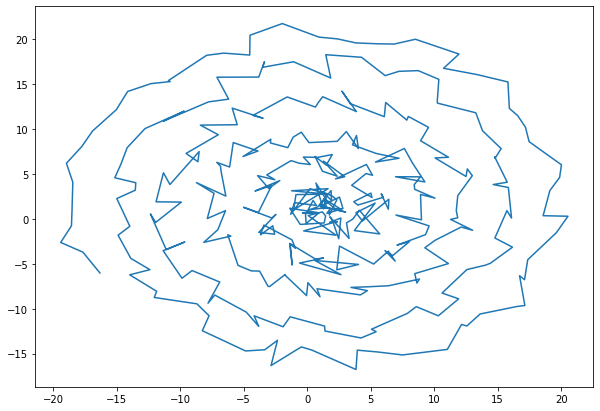

In [16]:
fig = plt.figure(figsize = (10, 7))
r = np.linspace(0,20,360)
t = np.linspace(0,2000,360)
x_n = 3 * np.random.rand(360)
y_n = 3 * np.random.rand(360)
x = r*np.cos(np.radians(t)) + x_n
y = r*np.sin(np.radians(t)) + y_n
plt.plot(x,y);

## Data preprocessing

Similar to before we normalize the inputs and also split them between train and test.

We can also visualize x, and y independent of each other vs. time

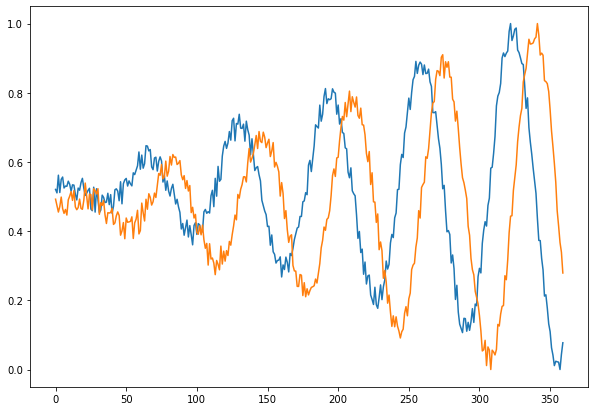

In [17]:
data_x = x.reshape(-1, 1)
data_y = y.reshape(-1, 1)

scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

normalized_x = scaler_x.fit_transform(data_x)
normalized_y = scaler_y.fit_transform(data_y)

fig = plt.figure(figsize = (10, 7))
plt.plot(normalized_x)
plt.plot(normalized_y)

plt.show()

Train - Test split for both x and y datasets. We should not get confused by the second y that refers to target rather than coordinate. It was probably better to use different terms but I did this quickly.

In [18]:
test_size = 0.25
n = len(normalized_x)
split_point = int((1 - test_size) * n)

train_data_x  = normalized_x[0:split_point] 
test_data_x   = normalized_x[split_point:n]

train_data_y  = normalized_y[0:split_point] 
test_data_y   = normalized_y[split_point:n]

print(len(train_data_x), len(test_data_x))

270 90


Create datasets using the previous function:

In [19]:
past_points = 2

train_x_X, train_x_Y = make_data(train_data_x, past_points = past_points)
test_x_X, test_x_Y = make_data(test_data_x, past_points = past_points)

train_y_X, train_y_Y = make_data(train_data_y, past_points = past_points)
test_y_X, test_y_Y = make_data(test_data_y, past_points = past_points)

Reshaping and transforming to match torch LSTM format:

In [20]:
train_x_X = np.reshape(train_x_X, (train_x_X.shape[0], 1, train_x_X.shape[1]))
test_x_X = np.reshape(test_x_X, (test_x_X.shape[0], 1, test_x_X.shape[1]))
train_x_data_tensor   = torch.tensor(train_x_X, dtype = torch.float32)
train_x_target_tensor = torch.tensor(train_x_Y, dtype = torch.float32)
test_x_data_tensor   = torch.tensor(test_x_X, dtype = torch.float32)
test_x_target_tensor = torch.tensor(test_x_Y, dtype = torch.float32)


train_y_X = np.reshape(train_y_X, (train_y_X.shape[0], 1, train_y_X.shape[1]))
test_y_X = np.reshape(test_y_X, (test_y_X.shape[0], 1, test_y_X.shape[1]))
train_y_data_tensor   = torch.tensor(train_y_X, dtype = torch.float32)
train_y_target_tensor = torch.tensor(train_y_Y, dtype = torch.float32)
test_y_data_tensor   = torch.tensor(test_y_X, dtype = torch.float32)
test_y_target_tensor = torch.tensor(test_y_Y, dtype = torch.float32)

## Setting up the model(s)

We create two independent models one for the x coordinates and one for the y:

In [21]:
learning_rate = 5e-5
num_hidden_units = 4

model_x = LSTM_Regression(input_size = past_points, hidden_size = num_hidden_units)
loss_function_x = nn.MSELoss()
optimizer_x = torch.optim.Adam(model_x.parameters(), lr = learning_rate)


model_y = LSTM_Regression(input_size = past_points, hidden_size = num_hidden_units)
loss_function_y = nn.MSELoss()
optimizer_y = torch.optim.Adam(model_y.parameters(), lr = learning_rate)

## Training the model(s)

We train both models at the same time in one training loop.

In [22]:
model_x.train()
model_y.train()
for step in range(20000):
    output_x  = model_x(train_x_data_tensor)
    loss_x    = loss_function_x(output_x, train_x_target_tensor)
    
    output_y  = model_y(train_y_data_tensor)
    loss_y    = loss_function_y(output_y, train_y_target_tensor)
    
    if step % 1000 == 0:
        print("step " + str(step) + " Loss : " + str(loss_x.item() + loss_y.item()))
        
    optimizer_x.zero_grad()
    loss_x.backward()
    optimizer_x.step()
    
    optimizer_y.zero_grad()
    loss_y.backward()
    optimizer_y.step()    

step 0 Loss : 0.523512989282608
step 1000 Loss : 0.3479248285293579
step 2000 Loss : 0.21143396198749542
step 3000 Loss : 0.1187731996178627
step 4000 Loss : 0.06722020730376244
step 5000 Loss : 0.042106335051357746
step 6000 Loss : 0.03081041807308793
step 7000 Loss : 0.026598173193633556
step 8000 Loss : 0.02357526123523712
step 9000 Loss : 0.02063938125502318
step 10000 Loss : 0.017709629144519567
step 11000 Loss : 0.014080835389904678
step 12000 Loss : 0.0097603399772197
step 13000 Loss : 0.005868519307114184
step 14000 Loss : 0.003473585587926209
step 15000 Loss : 0.002657454926520586
step 16000 Loss : 0.002548802876845002
step 17000 Loss : 0.002527682459913194
step 18000 Loss : 0.0025058694882318377
step 19000 Loss : 0.0024822482373565435


## Data post-processing

Passing the inputs for both x and y datasets for the training and test splits and getting the predicttions.
Then detaching them from torch and formating them into right numpy for evaluation and visualization

In [23]:
model_x.eval()
model_y.eval()
test_x_y_hat = model_x.evaluate(test_x_data_tensor)
train_x_y_hat = model_x.evaluate(train_x_data_tensor)

loss_test_x    = loss_function_x(test_x_y_hat, test_x_target_tensor)
loss_train_x    = loss_function_x(train_x_y_hat, train_x_target_tensor)

print("MSE train x:" + str(loss_train_x))
print("MSE test x:" + str(loss_test_x))

test_y_y_hat = model_y.evaluate(test_y_data_tensor)
train_y_y_hat = model_y.evaluate(train_y_data_tensor)

loss_test_y    = loss_function_y(test_y_y_hat, test_y_target_tensor)
loss_train_y    = loss_function_y(train_y_y_hat, train_y_target_tensor)

print("MSE train y:" + str(loss_train_y))
print("MSE test y:" + str(loss_test_y))


MSE train x:tensor(0.0012)
MSE test x:tensor(0.0035)
MSE train y:tensor(0.0012)
MSE test y:tensor(0.0024)


In [24]:
train_x_y_hat = train_x_y_hat.detach().cpu().numpy()
train_x_y_hat = np.reshape(train_x_y_hat, (-1, 1))

test_x_y_hat = test_x_y_hat.detach().cpu().numpy()
test_x_y_hat = np.reshape(test_x_y_hat, (-1, 1))

train_y_y_hat = train_y_y_hat.detach().cpu().numpy()
train_y_y_hat = np.reshape(train_y_y_hat, (-1, 1))

test_y_y_hat = test_y_y_hat.detach().cpu().numpy()
test_y_y_hat = np.reshape(test_y_y_hat, (-1, 1))

In [25]:
predictions_x_train = np.empty_like(normalized_x)
predictions_x_train[:,:] = np.nan
predictions_x_train[past_points:split_point, :] = train_x_y_hat

predictions_x_test = np.empty_like(normalized_x)
predictions_x_test[:,:] = np.nan
predictions_x_test[split_point+past_points:n, :] = test_x_y_hat

predictions_x_train = scaler_x.inverse_transform(predictions_x_train)
predictions_x_test = scaler_x.inverse_transform(predictions_x_test)


predictions_y_train = np.empty_like(normalized_y)
predictions_y_train[:,:] = np.nan
predictions_y_train[past_points:split_point, :] = train_y_y_hat

predictions_y_test = np.empty_like(normalized_y)
predictions_y_test[:,:] = np.nan
predictions_y_test[split_point+past_points:n, :] = test_y_y_hat

predictions_y_train = scaler_y.inverse_transform(predictions_y_train)
predictions_y_test = scaler_y.inverse_transform(predictions_y_test)

## Visualizing the output

First we look at the x and y prediction for their train and test splits.

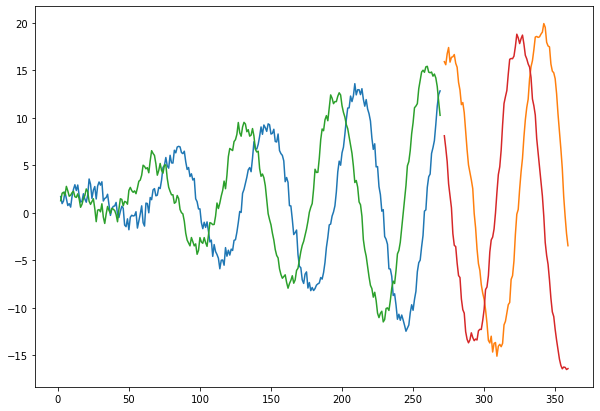

In [26]:
fig = plt.figure(figsize = (10, 7))
plt.plot(predictions_y_train)
plt.plot(predictions_y_test)
plt.plot(predictions_x_train)
plt.plot(predictions_x_test)

plt.show()

Next, we plot the x and y versus each other to get the spiral shape. We can compare with the original data.

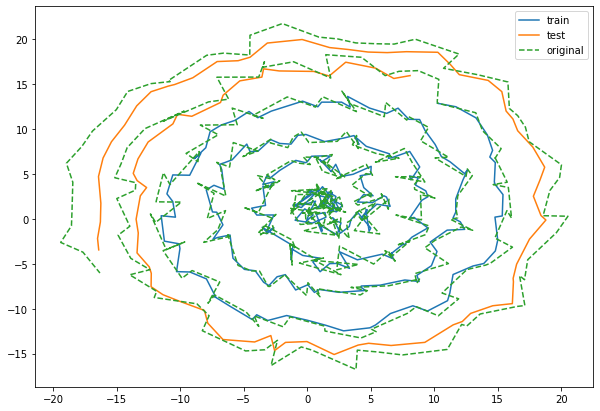

In [27]:
fig = plt.figure(figsize = (10, 7))
plt.plot(predictions_x_train, predictions_y_train, label = 'train')
plt.plot(predictions_x_test, predictions_y_test,label = 'test')
plt.plot(x, y, '--', label = 'original')
plt.legend()
plt.show()

## Discussion:

At first it seems that the model is also learning the noise in the motion. But that is not correct. The x and y are treated independently and when we look at them separately in the figure before the spiral motion that becomes more clear. This shows the advantage of treating them separately in this case because we were able to predict highly non-linear motion in presense of noise.

Overall, it seems LSTM concept could be a powerful tool for regression predict problems.